# Consinstently estimating Markov Chains with Noisy Aggregated Data

Notebook con esperimenti numerici per il seminario di fine corso di Metodi Numerici per le Catene di Markov (versione stazionaria)

In [1]:
# to avoid the pain of restarting the kernel each time
%load_ext autoreload
%autoreload 2

In [2]:
# Import some basic stuff
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utilities.estimators import P_mom_stationary, P_cls_stationary
from utilities.data import generate_random_P, create_observations
from utilities.num_methods import compute_stationary_LU_GTH

In [3]:
# Fissiamo il numero di stati
S = 10

# Fissiamo il seed per la riproducibilità degli esperimenti
SEED = 74 	# 74 è il mio numero preferito, l'importante è NON usare 42

In [4]:
SUBDIRECTORY = f'experiment_seed={SEED}'
PATH = os.path.join('data',SUBDIRECTORY)

# Let's create the directory, if it doesn't exist yet
os.makedirs(PATH, exist_ok=True)

## Experiment n° 2

For the second experiment, we replicate what we've done so far using a random stochastic matrix generated using random uniform numbers, instead of using the Dirichlet distribution.

I put it in a separate notebook to not mess up the variables that were declared in the `MNCM_notebook_stationary.ipynb`, since I'm reusing the same names (hence I'd be reassigning them).

### Generate $P$ and $\pi$

Let's generate the transition matrix and compute its steady-state vector

In [5]:
# No funny Dirichlet stuff
P = generate_random_P(S, rng=np.random.default_rng(SEED))	
pi_0 = compute_stationary_LU_GTH(P)

Let's visualize what we got

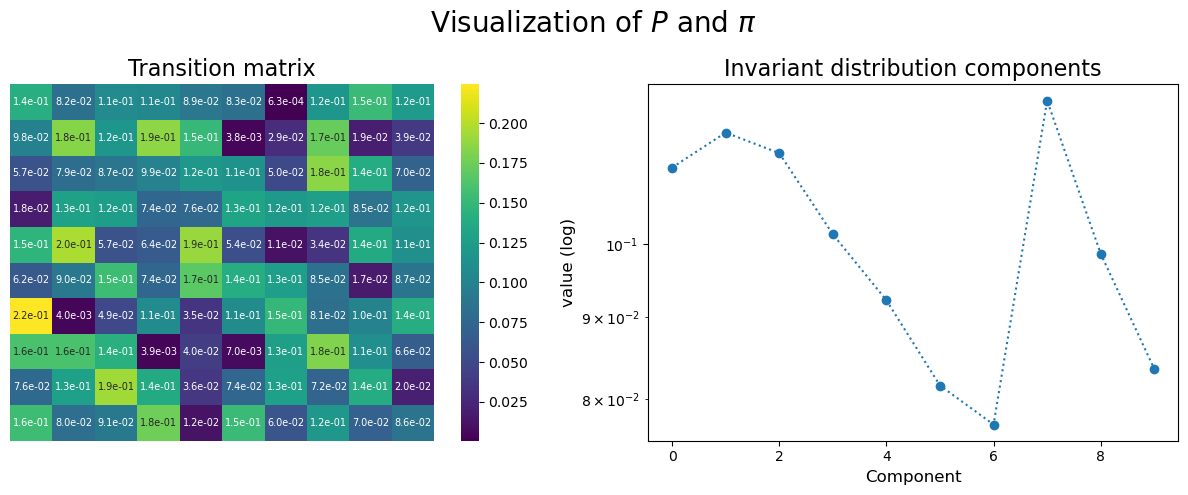

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
fig.suptitle(r'Visualization of $P$ and $\pi$', fontsize=20)

sns.heatmap(P, ax = ax[0], cmap='viridis', 
			annot=True, fmt=".1e", annot_kws={"size": 7},
			cbar=True, xticklabels=False, yticklabels=False)
ax[0].set_title("Transition matrix entries", fontsize=16)

ax[1].plot(pi_0, linestyle=':', marker='o')
ax[1].set_title("Invariant distribution components", fontsize=16)
ax[1].set_xlabel('Component', fontsize=12)
ax[1].set_ylabel('value (log)', fontsize=12)
ax[1].set_yscale('log')

plt.tight_layout()
plt.show()

... and print the $\lvert\lvert\pi^t\cdot(I-P)\rvert\rvert_2$

In [7]:
print(f"The norm of pi_gth @ (I-P) = {np.linalg.norm(pi_0@(np.eye(S)-P))}")

The norm of pi_gth @ (I-P) = 4.80584155013004e-17


Let's save these quantities

In [8]:
with open(os.path.join(PATH,f'P__SEED={SEED}.npy'),'wb') as file:
	np.save(file, P)

with open(os.path.join(PATH,f'pi__SEED={SEED}.npy'),'wb') as file:
	np.save(file, pi_0)

### Generate the data (i.e. simulate the Markov Chain)

We use the same range as before for $T, K, N, \dots$

In [9]:
# choice of the error's distribution parameters
alpha = [1, 0.5, 0.25]
variance = [0, 1, 5]

# ranges
T_range = [10**k for k in range(1,5)]	#range(1,3)
K_range = [1, 2, 5, 10, 20, 50]			#[1, 5, 20, 50]

# other parameters
n_reps = 10
N = 100

Let's move on and **load** the quantities we just saved

In [10]:
with open(os.path.join(PATH,f'P__SEED={SEED}.npy'),'rb') as file:
	P = np.load(file)

with open(os.path.join(PATH,f'pi__SEED={SEED}.npy'),'rb') as file:
	pi_0 = np.load(file)

Now is time for the **data creation**

In [11]:
from utilities.data import return_subdir_name, save_observation

from itertools import product
from tqdm import tqdm

prod = product(T_range, K_range, range(len(alpha)), ['gaussian','binomial'])
for T, K, i, noise_type in tqdm(prod):
	# Get parameter, distinguishing the two cases
	parameter = np.sqrt(variance[i]) if noise_type=='gaussian' else alpha[i]
	
	# Create subdirectory name according to a standard
	subdir_name = return_subdir_name(T=T, K=K, S=S, N=N,
								  noise_type=noise_type,
								  parameter=parameter)
	# Create the path of the subdirectory in which the arrays corresponding to
	# the given configurations of parameters have to be stored
	subdir_path = os.path.join(PATH,'observations',subdir_name)

	# Invariant: the noisy and original observations are either both present
	# or not present.
	# We check that the subdirectory doesn't exist, or that it exists but is empty
	if not os.path.exists(subdir_path) or not os.listdir(subdir_path):
		os.makedirs(subdir_path, exist_ok=True)

		# Create the n_reps observations to fill the folder right away
		for rep in range(n_reps):
			# Create name of the file in which to save the arrays
			n_filename = f"n_t_arr__repetition={rep}"
			y_filename = f"y_t_arr__repetition={rep}"
			# This is "complicazione affari semplici"
			# At the very least let's save one copy instead of n_reps
			par_name_val = "stdev" if noise_type=='gaussian' else 'alpha'
			A_filename = f"A_noise_type={noise_type}_{par_name_val}={parameter}"
		
			n_t_array, y_t_array, A = create_observations(
											T=T, K=K, N=N,
											P=P, pi_0=pi_0,
											noise_type=noise_type, 
											parameter=parameter)

			save_observation(array=n_t_array,
							filename = n_filename,
							path=subdir_path)
			
			save_observation(array=y_t_array,
							filename = y_filename,
							path=subdir_path)
			
			save_observation(array=A,
							filename=A_filename,
							path=subdir_path)
	else:
		# In case the directory already exists and has files inside, 
		# we just check that there's the correct number of them
		num_files = len(os.listdir(subdir_path))
		assert num_files == 2*n_reps+1, f"Error: in {subdir_name} there are {num_files} files, there should be 2*n_+1 reps = {2*n_reps}"

144it [28:11, 11.75s/it] 


### Computation of the estimators

Now we can compute the estimators and their error, using the stored simulations.

In [14]:
from utilities.data import load_observation

# Yeah let's see the zero divisions why not
gauss_errors, binomial_errors = [], []
zero_division_configurations = []

def error_computation(M:np.ndarray) -> float: 
    sqnorm = (np.linalg.norm(M-P,'fro')**2)
    return sqnorm/(S**2)

prod = product(T_range, K_range, range(len(alpha)), ['gaussian','binomial'])
for T, K, i, noise_type in tqdm(prod):
    # Get parameter, distinguishing the two cases
	parameter = np.sqrt(variance[i]) if noise_type=='gaussian' else alpha[i]
	# Create a dictionary to store the data, with parameters value
	dict_entry = {
		'noise_type': noise_type,
		'TxK': T*K,
	}
	if noise_type == 'gaussian':
		dict_entry['stdev'] = parameter
	else:
		dict_entry['alpha'] = parameter

	# Get the name of the subdirectory relative to the current params config
	obs_subdir_name = return_subdir_name(T=T, K=K, S=S, N=N,
								  noise_type=noise_type,
								  parameter=parameter)
	# Get the path of the subdirectory
	obs_subdir_path = os.path.join(PATH,'observations',obs_subdir_name)

	# We check that the path exists and has data.
	# This could be done more elegantly with exceptions maybe, but should be ok
	if not os.path.exists(obs_subdir_path) or not os.listdir(obs_subdir_path):
		print(f"The directory {obs_subdir_path} is empty or doesn't exist")
		print("Please generate the data by running the cell above")
		break

	# Just like the author, the computations are repeated 
	# (of course we already have the data)
	for rep in range(n_reps):
		# Get name of the file in which the arrays are saved
		n_filename = f"n_t_arr__repetition={rep}"
		y_filename = f"y_t_arr__repetition={rep}"
		par_name_val = "stdev" if noise_type=='gaussian' else 'alpha'
		A_filename = f"A_noise_type={noise_type}_{par_name_val}={parameter}"

		n_t_array = load_observation(filename=n_filename, path=obs_subdir_path)
		y_t_array = load_observation(filename=y_filename, path=obs_subdir_path)
		A_t_arr = load_observation(filename=A_filename, path=obs_subdir_path)

		with warnings.catch_warnings(record=True) as w:
			# I'm being lazy and catching all warnings, but all I really care is 
			# RuntimeWarning: invalid value encountered in divide
			warnings.simplefilter("always")

			# method of moments estimator
			P_mom, mu_hat, _ = P_mom_stationary(y_array=y_t_array, A=A_t_arr, N=N)
			# conditional least squares estimator
			P_cls = P_cls_stationary(y_array=y_t_array)

			# In case or zero divisions during P_mom computation, err=np.nan
			# Thus, something may be made about it
			err_mom = error_computation(P_mom)
			err_cls = error_computation(P_cls)
			
			dict_entry[f'error_MoM_{rep}'] = err_mom
			dict_entry[f'error_CLS_{rep}'] = err_cls

			# Store the error, with its parameters, into the list
			if noise_type=='gaussian':
				gauss_errors.append(dict_entry)
			else:
				binomial_errors.append(dict_entry)

			if w:
				bad_config = {
					'T':T,
					'K':K,
					'noise_type':noise_type,
					'n_t': n_t_array,
					'y_t': y_t_array,
					'A_t': A_t_arr,
					'parameter': parameter,
					'P_mom': P_mom,
					'mu_hat': mu_hat
				}
				zero_division_configurations.append(bad_config)
			

0it [00:00, ?it/s]

144it [00:20,  7.03it/s]


#### `NaN`s checking

Let's verify which cases gave us divisions by zero


In [15]:
bad_outcomes_df = pd.DataFrame(zero_division_configurations)

bad_gaussian_df = bad_outcomes_df[bad_outcomes_df['noise_type'] == 'gaussian']
bad_binomial_df = bad_outcomes_df[bad_outcomes_df['noise_type'] == 'binomial']

KeyError: 'noise_type'

##### Which noise is more problematic?

Firstly, let's see which noise model yielded the most divisions by zero

In [ ]:
# Count the number of rows for each noise type
noise_counts = bad_outcomes_df['noise_type'].value_counts()

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=noise_counts.index,  y=noise_counts.values, 
			palette=['orange', 'teal'], edgecolor='black',
			legend=False, hue=noise_counts.index,
			ax=ax)

# Display the absolute number in the middle of each bar
for i in range(len(noise_counts)):
	ax.text(i, noise_counts.values[i] / 2, str(noise_counts.values[i]), ha='center', va='center', fontsize=12, color='white')

ax.set_xlabel('Noise Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Number of bad outcomes for each noise type', fontsize=14, fontweight='bold')
plt.show()

##### Zero divisions?

In [ ]:
all_mu_have_a_zero = bad_outcomes_df['mu_hat'].apply(lambda arr: np.any(arr == 0)).all()

if all_mu_have_a_zero:
	print("All the mean vectors (computed from the noisy observations, mind you) have a zero somewhere")
else:
	print("At least one mean vector has all nonzero components")

##### Ranges for $T$ and $K$

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Distribution of T and K values", fontweight='bold', fontsize=22)

# Plot for bad_gaussian_df T values
sns.barplot(x=bad_gaussian_df['T'].value_counts().index, 
			y=bad_gaussian_df['T'].value_counts().values, 
			ax=ax[0, 0], 
			color='orange', edgecolor='black')
#sns.histplot(bad_gaussian_df['T'], ax=ax[0,0], color='orange', discrete=True)
ax[0, 0].set_title('Distribution of T values (Gaussian)', fontsize=18)
ax[0, 0].set_xlabel('T', fontsize=14)
ax[0, 0].set_ylabel('Frequency', fontsize=14)
#xticks = sorted(set(ax[0, 0].get_xticks()[:-1]).union(set(bad_gaussian_df['T'].unique())))
#ax[0, 0].set_xticks(xticks)

# Plot for bad_gaussian_df K values
sns.histplot(bad_gaussian_df['K'], ax=ax[0, 1], color='orange', discrete=True)
ax[0, 1].set_title('Distribution of K values (Gaussian)', fontsize=18)
ax[0, 1].set_xlabel('K', fontsize=14)
ax[0, 1].set_ylabel('Frequency', fontsize=14)
xticks = sorted(set(ax[0, 1].get_xticks()[1:]).union(set(bad_gaussian_df['K'].unique())))
ax[0, 1].set_xticks([int(x) for x in xticks])

# Plot for bad_binomial_df T values
sns.barplot(x=bad_binomial_df['T'].value_counts().index, 
			y=bad_binomial_df['T'].value_counts().values, 
			ax=ax[1, 0], 
			color='teal', edgecolor='black')
ax[1, 0].set_title('Distribution of T values (Binomial)', fontsize=18)
ax[1, 0].set_xlabel('T', fontsize=14)
ax[1, 0].set_ylabel('Frequency', fontsize=14)
#xticks = sorted(set(ax[1, 0].get_xticks()[:-1]).union(set(bad_binomial_df['T'].unique())))
#ax[1, 0].set_xticks(xticks)

# Plot for bad_binomial_df K values
sns.histplot(bad_binomial_df['K'], ax=ax[1, 1], color='teal', discrete=True)
ax[1, 1].set_title('Distribution of K values (Binomial)', fontsize=18)
ax[1, 1].set_xlabel('K', fontsize=14)
ax[1, 1].set_ylabel('Frequency', fontsize=14)
xticks = sorted(set(ax[1, 1].get_xticks()[1:]).union(set(bad_binomial_df['K'].unique())))
ax[1, 1].set_xticks(xticks)

plt.tight_layout()
plt.show()

### Let's move on

Let's create some dataframes and compute the means beforehand

In [ ]:
# Create dataframes
gauss_df = pd.DataFrame(gauss_errors)
binom_df = pd.DataFrame(binomial_errors)

# Compute the means of the repeated observations
gauss_df['mean_MoM'] = gauss_df[[f'error_MoM_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
gauss_df['mean_CLS'] = gauss_df[[f'error_CLS_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
binom_df['mean_MoM'] = binom_df[[f'error_MoM_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
binom_df['mean_CLS'] = binom_df[[f'error_CLS_{i}' for i in range(n_reps)]].mean(axis=1).dropna()

Let's peek at what we've got

In [62]:
gauss_df.head()

,noise_type,TxK,stdev,error_MoM_0,error_CLS_0,error_MoM_1,error_CLS_1,error_MoM_2,error_CLS_2,error_MoM_3,...,error_MoM_6,error_CLS_6,error_MoM_7,error_CLS_7,error_MoM_8,error_CLS_8,error_MoM_9,error_CLS_9,mean_MoM,mean_CLS
0,gaussian,10,0.0,0.166744,0.527872,0.075858,1.159666,0.148285,0.707351,0.048284,...,0.025458,2.005851,0.032589,0.217139,0.058781,0.167576,0.109631,31.079492,0.083198,3.842258
1,gaussian,10,0.0,0.166744,0.527872,0.075858,1.159666,0.148285,0.707351,0.048284,...,0.025458,2.005851,0.032589,0.217139,0.058781,0.167576,0.109631,31.079492,0.083198,3.842258
2,gaussian,10,0.0,0.166744,0.527872,0.075858,1.159666,0.148285,0.707351,0.048284,...,0.025458,2.005851,0.032589,0.217139,0.058781,0.167576,0.109631,31.079492,0.083198,3.842258
3,gaussian,10,0.0,0.166744,0.527872,0.075858,1.159666,0.148285,0.707351,0.048284,...,0.025458,2.005851,0.032589,0.217139,0.058781,0.167576,0.109631,31.079492,0.083198,3.842258
4,gaussian,10,0.0,0.166744,0.527872,0.075858,1.159666,0.148285,0.707351,0.048284,...,0.025458,2.005851,0.032589,0.217139,0.058781,0.167576,0.109631,31.079492,0.083198,3.842258


In [63]:
binom_df.head()

,noise_type,TxK,alpha,error_MoM_0,error_CLS_0,error_MoM_1,error_CLS_1,error_MoM_2,error_CLS_2,error_MoM_3,...,error_MoM_6,error_CLS_6,error_MoM_7,error_CLS_7,error_MoM_8,error_CLS_8,error_MoM_9,error_CLS_9,mean_MoM,mean_CLS
0,binomial,10,1.0,0.058141,5.823966,0.111143,0.660328,0.101314,7.760431,0.086036,...,0.075024,0.601212,0.036095,0.761469,0.027101,0.74679,0.040161,0.623124,0.074411,1.907571
1,binomial,10,1.0,0.058141,5.823966,0.111143,0.660328,0.101314,7.760431,0.086036,...,0.075024,0.601212,0.036095,0.761469,0.027101,0.74679,0.040161,0.623124,0.074411,1.907571
2,binomial,10,1.0,0.058141,5.823966,0.111143,0.660328,0.101314,7.760431,0.086036,...,0.075024,0.601212,0.036095,0.761469,0.027101,0.74679,0.040161,0.623124,0.074411,1.907571
3,binomial,10,1.0,0.058141,5.823966,0.111143,0.660328,0.101314,7.760431,0.086036,...,0.075024,0.601212,0.036095,0.761469,0.027101,0.74679,0.040161,0.623124,0.074411,1.907571
4,binomial,10,1.0,0.058141,5.823966,0.111143,0.660328,0.101314,7.760431,0.086036,...,0.075024,0.601212,0.036095,0.761469,0.027101,0.74679,0.040161,0.623124,0.074411,1.907571


And plot it

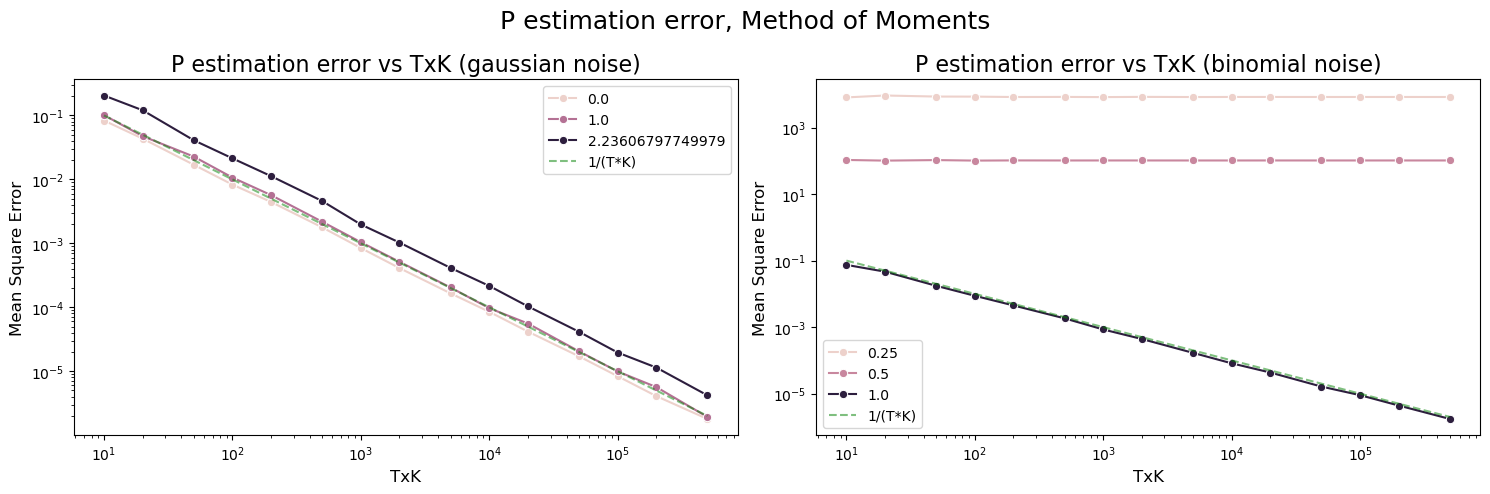

In [67]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i, noise_type in enumerate(['gaussian', 'binomial']):
    data_che_uso = gauss_df if noise_type == 'gaussian' else binom_df
    small_df = data_che_uso.copy()
    small_df.drop(columns=[f'error_CLS_{i}' for i in range(n_reps)],inplace=True)
    hue_val = 'stdev' if noise_type == 'gaussian' else 'alpha'
    # Plot the errors
    sns.lineplot(data=small_df, x='TxK', y='mean_MoM', 
                 err_style='bars', errorbar='ci',
                 hue=hue_val, ax=ax[i], marker='o')
    # Plot 1/(T*K)
    ax[i].plot(data_che_uso['TxK'], 1/data_che_uso['TxK'], 
               linestyle='--', color='green', alpha = 0.5,
               label='1/(T*K)')
    
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('TxK', fontsize=12)
    ax[i].set_ylabel('Mean Square Error', fontsize=12)
    ax[i].set_title(f'P estimation error vs TxK ({noise_type} noise)', fontsize=16)
    ax[i].legend()

fig.suptitle('P estimation error, Method of Moments', fontsize=18)
plt.tight_layout()
plt.show()

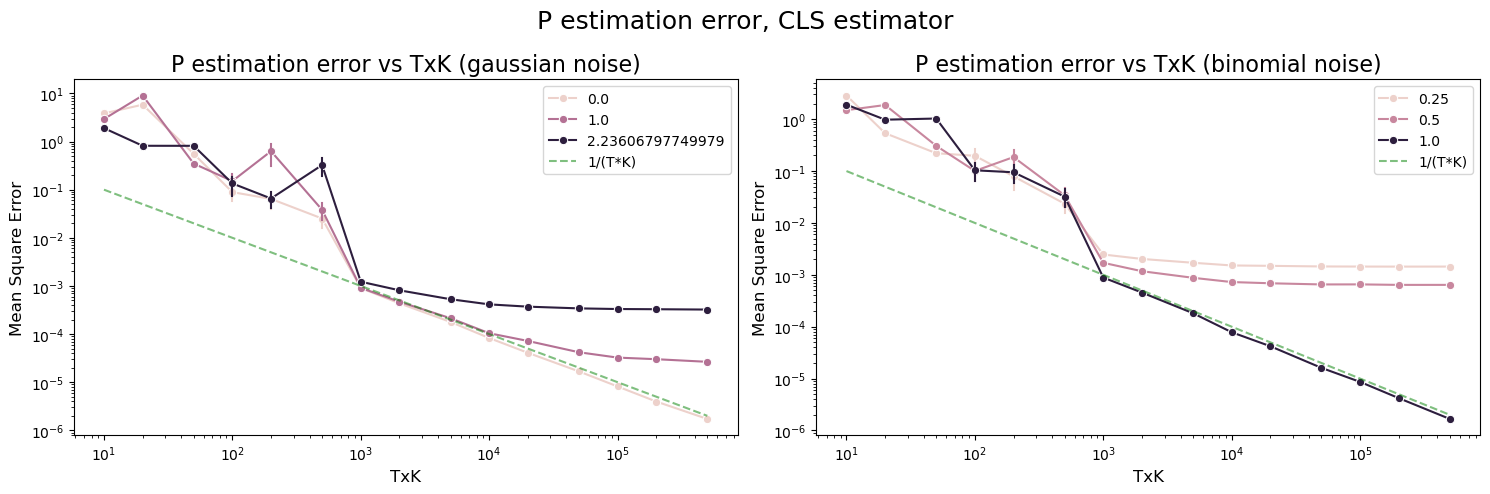

In [70]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('P estimation error, CLS estimator', fontsize=18)

for i, noise_type in enumerate(['gaussian', 'binomial']):
    data_che_uso = gauss_df if noise_type == 'gaussian' else binom_df
    small_df = data_che_uso.copy()
    small_df.drop(columns=[f'error_MoM_{i}' for i in range(n_reps)],inplace=True)
    hue_val = 'stdev' if noise_type == 'gaussian' else 'alpha'
    # Plot the errors
    sns.lineplot(data=small_df, x='TxK', y='mean_CLS', 
                 err_style='bars', errorbar='ci',
                 hue=hue_val, ax=ax[i], marker='o')
    # Plot 1/(T*K)
    ax[i].plot(data_che_uso['TxK'], 1/data_che_uso['TxK'], 
               linestyle='--', color='green', alpha = 0.5,
               label='1/(T*K)')
    
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('TxK', fontsize=12)
    ax[i].set_ylabel('Mean Square Error', fontsize=12)
    ax[i].set_title(f'P estimation error vs TxK ({noise_type} noise)', fontsize=16)
    ax[i].legend()

plt.tight_layout()
plt.show()